In [1]:
import polars as pl
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from src.utils import construct_sparse_adj_mat, load_json, augment_idx_feature
import json
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
)
from collections import defaultdict

In [2]:
with initialize(config_path="../configs/filepaths", version_base=None):
    fps = compose(config_name="base")

pred_dir = Path(fps.results) / "predictions"
save_to = Path(fps.artifacts) / "figures" / "error_analysis"

In [3]:
task = 'rcmcs'  # 'rcmcs' or 'arc'

if task == 'rcmcs':
    run_ids = {
        "rc_agg": "da9ed201898a451a8a822cf1a30ec30b",
        "rc_cxn": "af29e2f62cf34bf2824dc8c72e086da5",
        "bom": "d1a3cc3f1d36488e8222efda0d595914",
        "cgr": "e627a08cec3c47e18b4fd9f1ade6b9fe",
        "clipzyme": "clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold",
        "rxnfp": "bafce811361c4d19afe7919fb4666fb2",
        "drfp": "36a93d8131bd460599ef98740f8d322d",
        "mfp": "04cc886dade64a68a84b151ddd92cef2",
    }
elif task == 'arc':
    run_ids = {
        "rc_agg": "30ed98a93bb149f6b7b6c08779e95915",
        "rc_cxn": "874ef317e1b7403c9be3665c3c301d90",
        "bom": "35d782fa639e4035b08d5c74a4f002f9",
    }

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "clipzyme": "CLIPZyme",
    "rxnfp": "RXNFP",
    "drfp": "DRFP",
    "mfp": "Morgan fingerprint",
}

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "rxnfp": "silver",
    "mfp": "black",
    "drfp": "dimgray",
    "clipzyme": "maroon",
}

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

metric_fcns = {
    "roc_auc": roc_auc_score,
    "fpr": fpr,
    "fnr": fnr,
}

x_labels = {
    'n_rcts_pdts': 'Number of reactants + products',
    'n_atoms_chunk': 'Number of atoms',
    'protein_seq_len_chunk': 'Protein sequence length (# residues)',
    'ec1': 'EC level 1',
    'ec2': 'EC level 2',
    'rxnmapper_confidence_chunk': 'RXNMapper confidence',
}

rcmcs_threshold = 0.7

In [4]:
preds = {
    k: pl.read_parquet(pred_dir / v / "target_output.parquet") for k, v in run_ids.items()
}

best_thresholds = {}
for name, id in run_ids.items():
    if not (pred_dir / id / 'best_thresholds.json').exists():
        print(f"No thresholds saved for {name}, skipping...")
        continue
    
    with open(pred_dir / id / 'best_thresholds.json', 'r') as f:
        this = json.load(f)

    best_thresholds[name] = this['10']

In [5]:
toc = pl.read_csv(
    Path(fps.data) / "sprhea" / "v3_folded_pt_ns.csv",
    separator='\t'
)

adj, idx_sample, idx_feature = construct_sparse_adj_mat(Path(fps.data) / "sprhea" / "v3_folded_pt_ns.csv")
_rxns = load_json(Path(fps.data) / "sprhea" / "v3_folded_pt_ns.json")

if task == 'arc':
    unobs_rxns = load_json(Path(fps.data) / "sprhea" / f"v3_folded_pt_ns_arc_unobserved_reactions.json")
    rxn_details = {**_rxns, **unobs_rxns}
    idx_feature = augment_idx_feature(idx_feature, unobs_rxns)
else:
    rxn_details = _rxns

rid2idx = {int(v) : k for k, v in idx_feature.items()}
pid2idx = {v : k for k, v in idx_sample.items()}
rxn_details = {rid2idx[int(k)]: v for k, v in rxn_details.items()}

with open(Path(fps.artifacts) / 'sprhea_folded_pt_ns_idx2ec.json', 'r') as f:
    rxn_idx2ec = json.load(f)
    rxn_idx2ec = {int(k): set(tuple(elt.split('.')) for elt in v) for k, v in rxn_idx2ec.items()}

Constructing v3_folded_pt_ns sparse adjacency matrix


In [6]:
ridx_2_n_atoms = {}
ridx_2_reactants_products = {}
for ridx, rxn in rxn_details.items():
    lhs, rhs = rxn['smarts'].split('>>')
    n_rcts = len(lhs.split('.'))
    n_pdts = len(rhs.split('.'))
    mol = Chem.MolFromSmarts(lhs)
    n_atoms = mol.GetNumAtoms()
    ridx_2_n_atoms[ridx] = n_atoms
    ridx_2_reactants_products[ridx] = n_rcts + n_pdts

In [7]:
pidx_2_seq_len = {
    pid2idx[row['Entry']]: len(row['Sequence'])
    for row in toc.iter_rows(named=True)
}

In [8]:
ec1 = {}
ec2 = {}
for idx, _ecs in rxn_idx2ec.items():
    for i in range(1,3):
        ec = list(set([".".join(elt[:i] )for elt in _ecs]))
        if i == 1:
            ec1[idx] = ec[0] if len(ec) > 0 else None
        else:
            ec2[idx] = ec[0] if len(ec) > 0 else None

In [9]:
preds['bom']

protein_idx,reaction_idx,pid,rid,y,logits,max_sim
i32,i32,str,str,i64,f32,f32
16113,5226,"""Q09KQ6""","""16449""",1,0.977414,0.5
21519,6100,"""P0DJQ7""","""9228""",1,0.633814,0.708333
5853,2476,"""P9WIN5""","""16898""",1,0.94093,0.976744
13019,4673,"""Q6F7B8""","""9043""",1,0.742991,0.893805
13020,4673,"""Q79FC3""","""9043""",1,0.084693,0.893805
…,…,…,…,…,…,…
4743,5038,"""Q5EA42""","""12910""",0,0.062223,0.0
7789,6102,"""P17585""","""13430""",0,0.000165,0.1
7824,2414,"""P38812""","""13106""",0,0.021014,0.746835


In [10]:
for k, pred in preds.items():
    pred = pred.with_columns(
        pl.col("protein_idx").replace_strict(pidx_2_seq_len).alias("protein_seq_len"),
        pl.col("reaction_idx").replace_strict(ridx_2_n_atoms).alias("n_atoms"),
        pl.col("reaction_idx").replace_strict(ridx_2_reactants_products).alias("n_rcts_pdts"),
        pl.col("reaction_idx").replace_strict(ec1, return_dtype=pl.String, default=None).alias("ec1"),
        pl.col("reaction_idx").replace_strict(ec2, return_dtype=pl.String, default=None).alias("ec2"),
        pl.col("logits").map_elements(lambda x : x > best_thresholds[k], return_dtype=pl.Int32).alias('y_pred'),
    )
    
    if task == 'rcmcs':
        pred = pred.filter(
            pl.col("ec1").is_not_null(),
            pl.col("ec2").is_not_null(),
            pl.col("max_sim") < rcmcs_threshold,
            
        )
    preds[k] = pred

/tmp/ipykernel_9134/2449844201.py:8: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("logits").map_elements(lambda x: ...)
with this one instead:
  + pl.col("logits") > k.replace_strict(best_thresholds)

  pl.col("logits").map_elements(lambda x : x > best_thresholds[k], return_dtype=pl.Int32).alias('y_pred'),
/tmp/ipykernel_9134/2449844201.py:8: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("logits").map_elements(lambda x: ...)
with this one instead:
  + pl.col("logits") > k.replace_strict(best_thresholds)

  pl.col("logits").map_elements(lambda x : x > best_thresholds[k], return_dtype=pl.Int32).alias('y_pred'),
/tmp/ipykernel_9134/2449844201.py:8: PolarsInefficientMa

In [11]:
n_chunks = 5

for col in ['n_atoms', 'protein_seq_len']:
    for k, pred in preds.items():
        percentiles = np.percentile(pred[col].to_list(), np.linspace(0, 100, n_chunks))
        chunk_labels = [f"<{int(percentiles[0])}"] + [f"{int(percentiles[i])}-{int(percentiles[i+1])}" for i in range(len(percentiles)-1)] + [f">{int(percentiles[-1])}"]
        pred = pred.with_columns(
            pl.col(col).cut(breaks=percentiles, labels=chunk_labels, left_closed=True).alias(f"{col}_chunk")
        )
        gb = pred.group_by(f"{col}_chunk").agg(
            pl.col("y").mean().alias("pos_frac"),
            pl.len().alias("n"),
        ).sort(f"{col}_chunk")
        black_list = gb.filter(pl.col("n") < 50)[f"{col}_chunk"].to_list()
        print(f"Excluding {black_list} for having less than 50 samples.")
        pred = pred.filter(
            ~pl.col(f"{col}_chunk").is_in(black_list)
        )
        preds[k] = pred

Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.


In [12]:
cluster_whitelist = ['rc_agg', 'rc_cxn', 'bom']
cluster_preds = {k: v for k, v in preds.items() if k in cluster_whitelist}
def clustered_bar_plot(group_col, metric, metrics_fcns=metric_fcns, preds=cluster_preds, labels=labels, x_labels=x_labels, colors=colors, save_to=save_to, task=task):
    '''
    Creates clustered bar plot with an x-tick for each unique value of `group_col` and as many
    bars per col as there are models in preds (names of which are keys in preds dict).
    '''
    fig, ax = plt.subplots(figsize=(14, 4))
    groups = sorted(preds[next(iter(preds))][group_col].unique().to_list())

    if "chunk" in group_col:
        groups = [
            elt[1] for elt in sorted(
                [ (float(elt.split('-')[0].replace('<','').replace('>','')), elt) for elt in groups ]
            )
        ]

    n_models = len(preds)
    width = 0.8 / n_models

    for i, (name, pred) in enumerate(preds.items()):
        vals = []
        for g in groups:
            sub = pred.filter(pl.col(group_col) == g)
            y_true = sub["y"].to_list()
            y_hat = sub["logits"].to_list() if metric == "roc_auc" else sub["y_pred"].to_list()
            vals.append(metrics_fcns[metric](y_true, y_hat))
        xs = [x + (i - (n_models - 1) / 2) * width for x in range(len(groups))]
        ax.bar(xs, vals, width=width, label=labels.get(name, name), color=colors.get(name))

    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(groups, rotation=45)
    ax.set_xlabel(x_labels.get(group_col, group_col))
    ax.set_ylabel(metric.replace('_', '-').upper())
    if metric == "roc_auc":
        ax.set_ylim([0.4, 1.05])
    ax.legend(bbox_to_anchor=(1.01, 1.0))
    fig.tight_layout()

    if save_to is not None:
        save_to.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_to / f"{task}_clustered_bar_{group_col}_{metric}.svg")

    return fig, ax

(<Figure size 1400x400 with 1 Axes>,
 <Axes: xlabel='Protein sequence length (# residues)', ylabel='FNR'>)

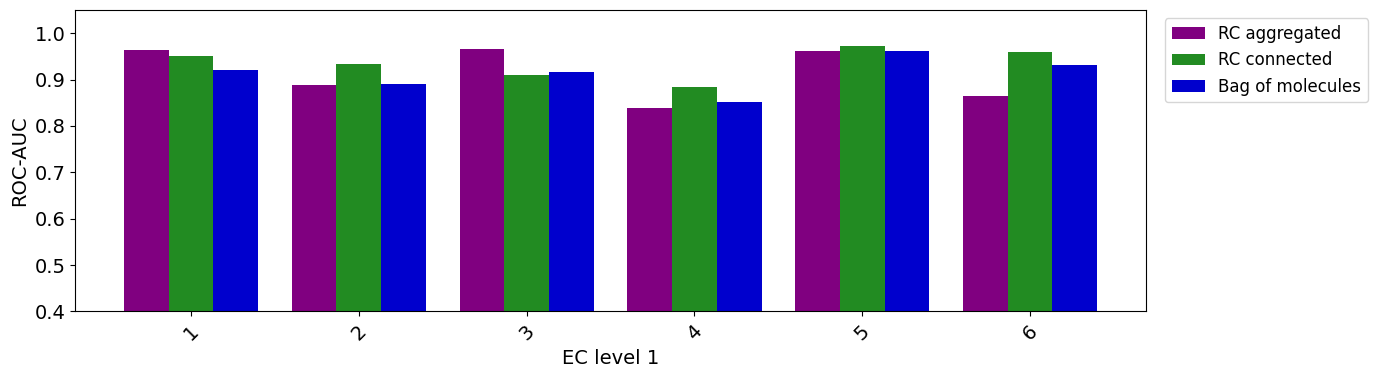

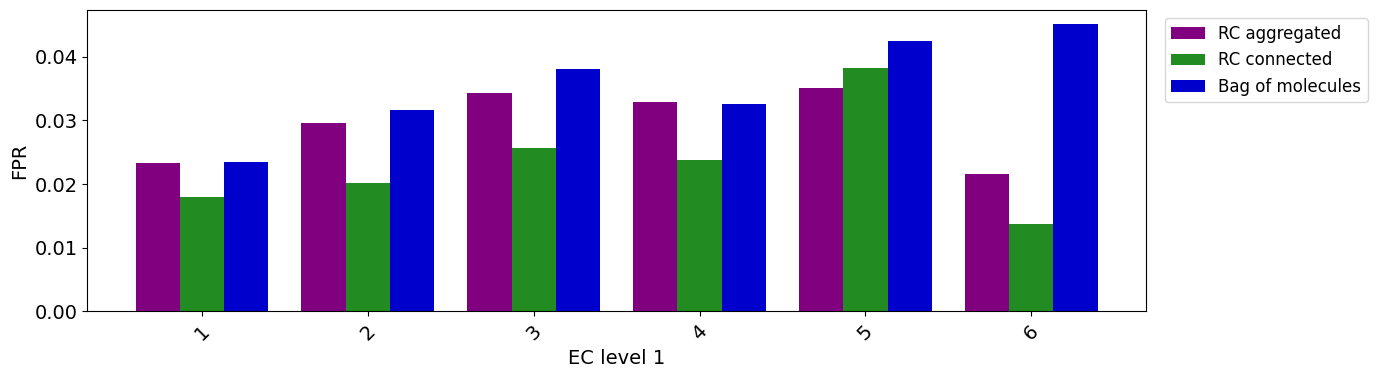

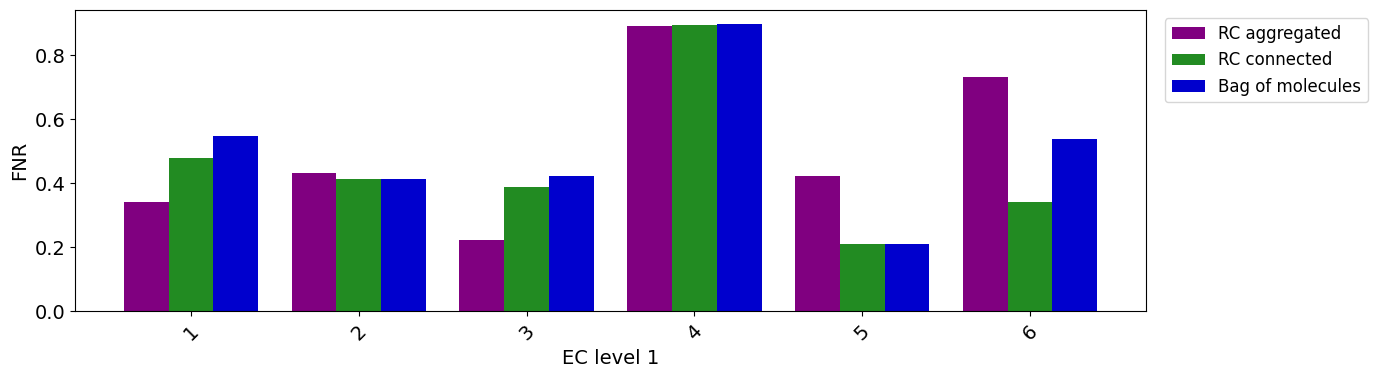

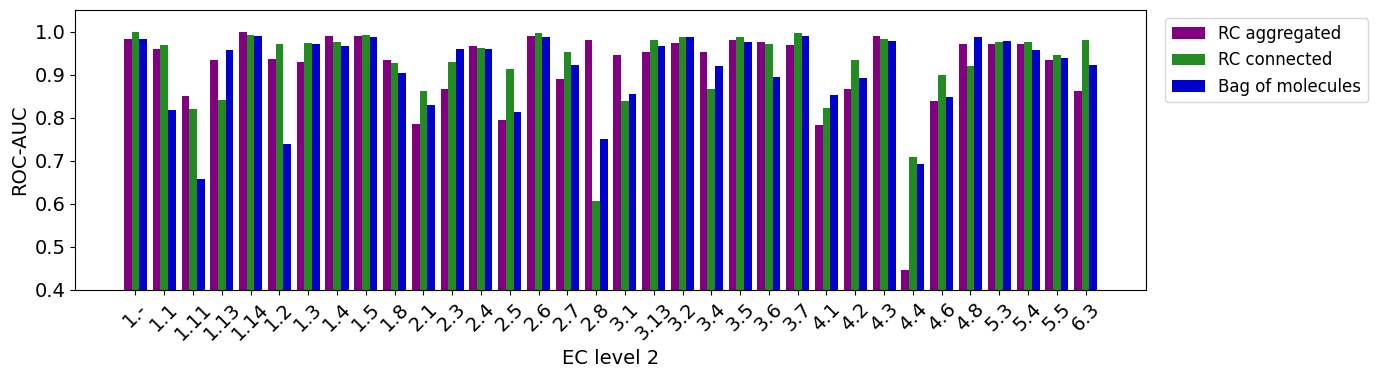

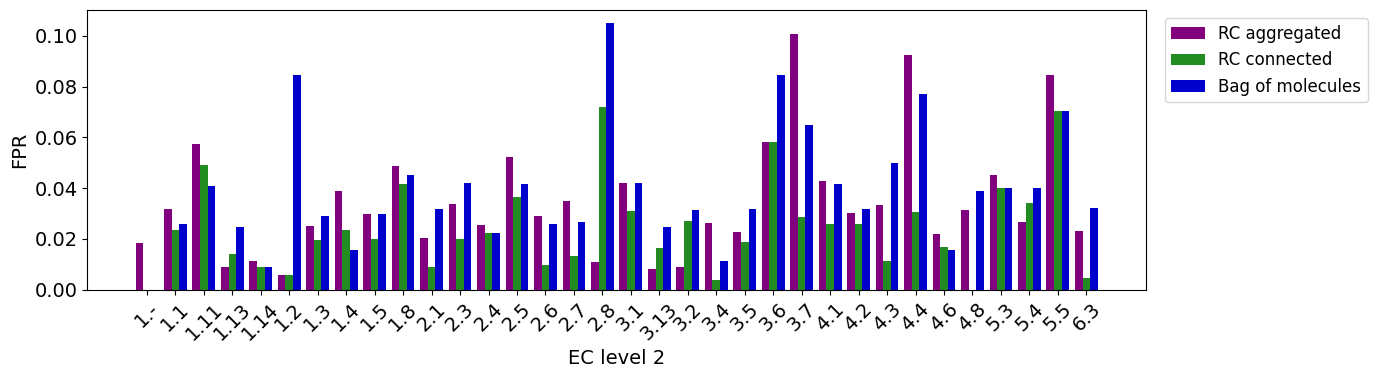

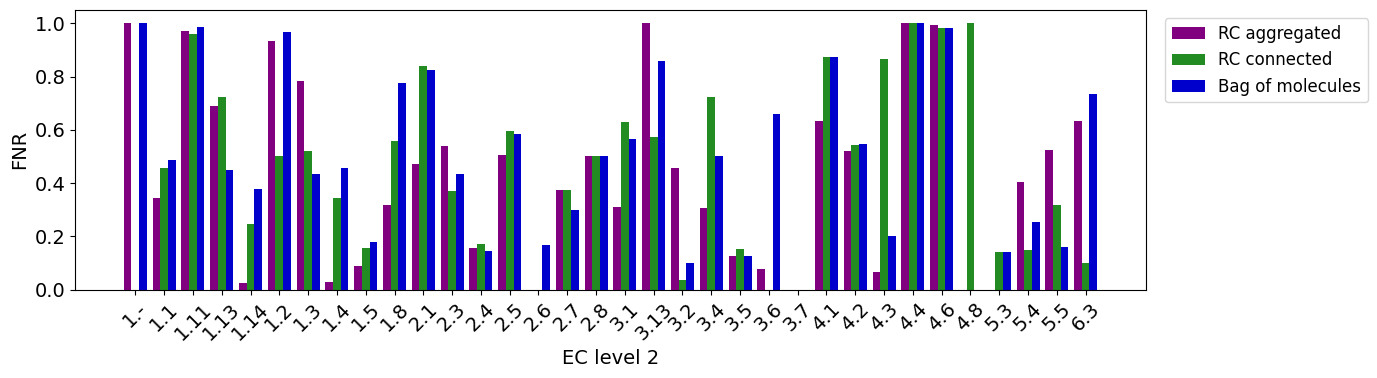

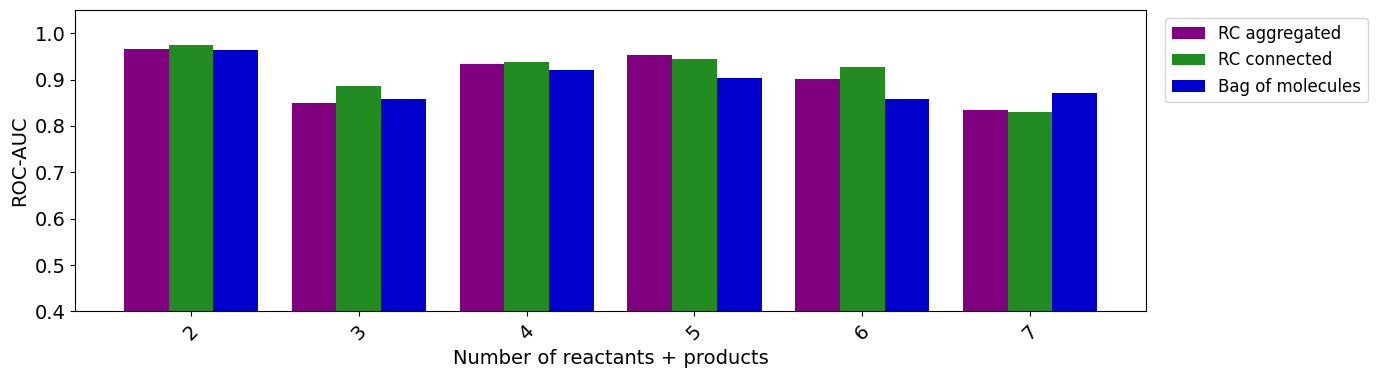

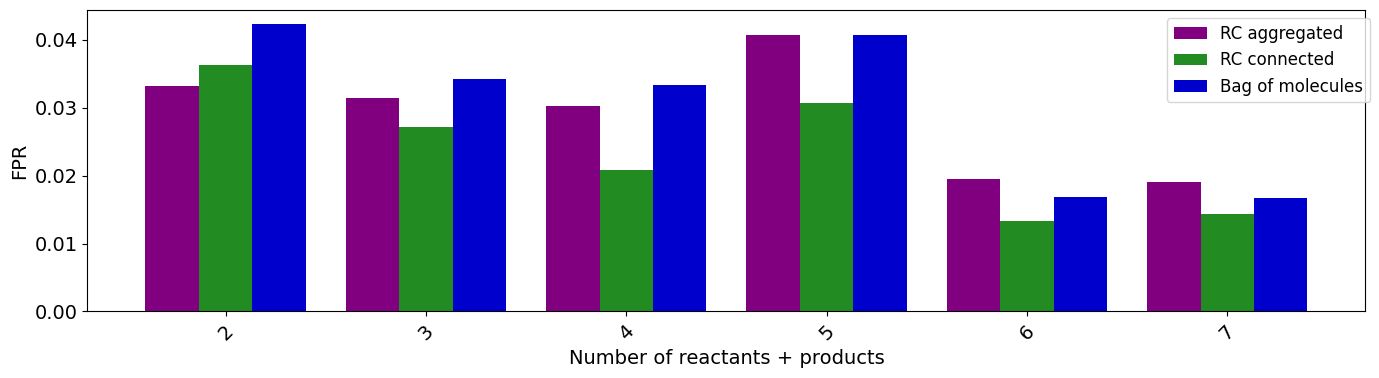

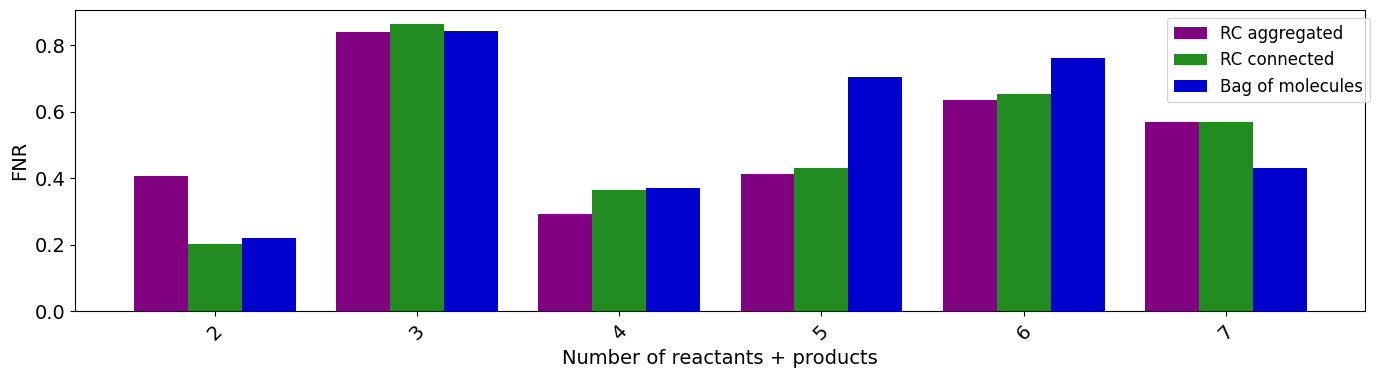

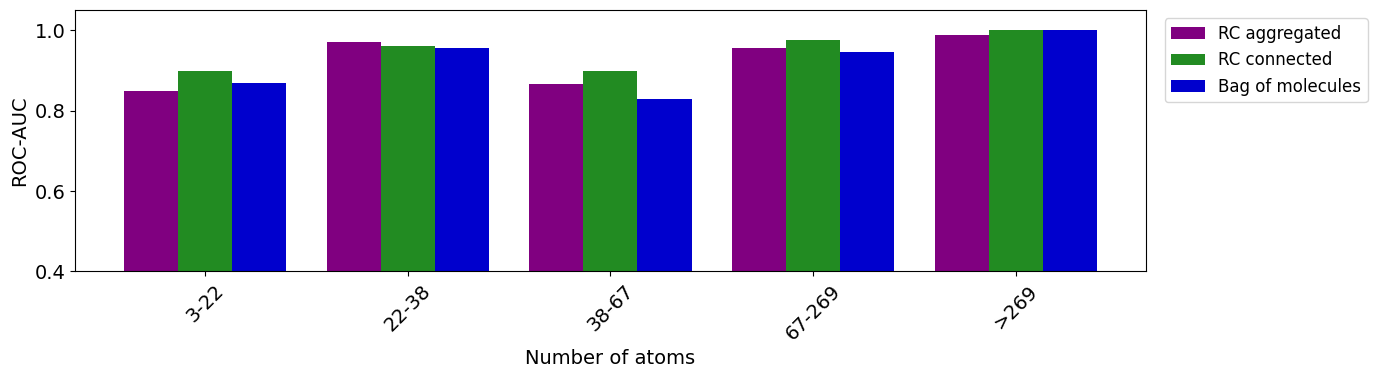

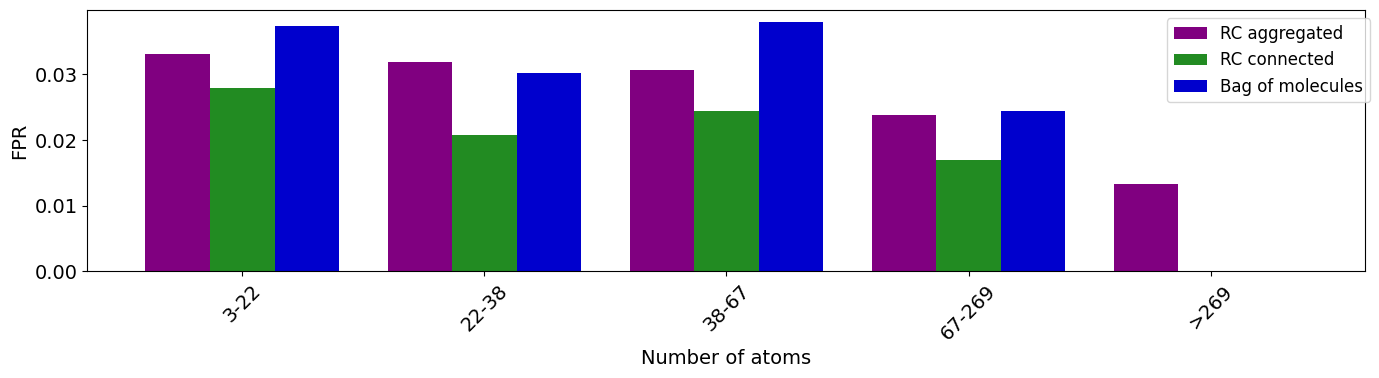

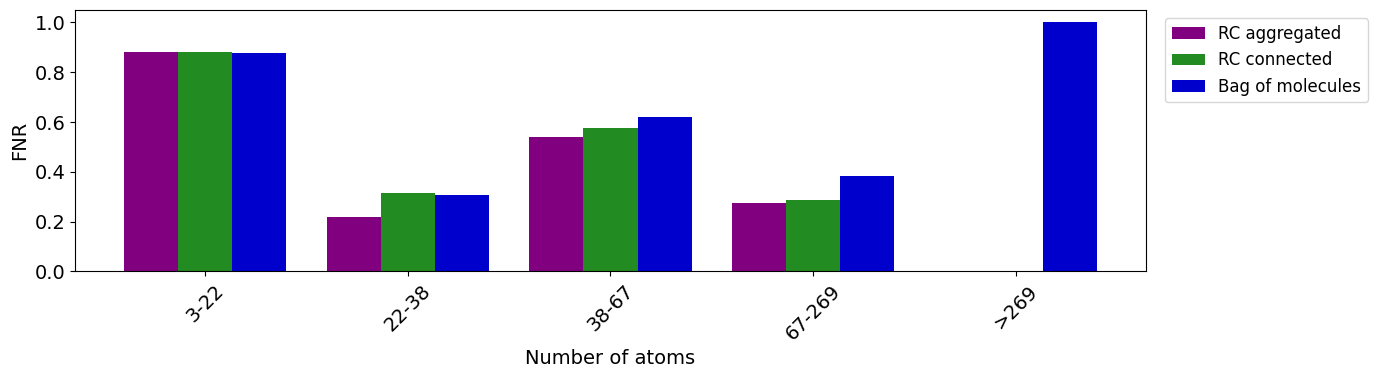

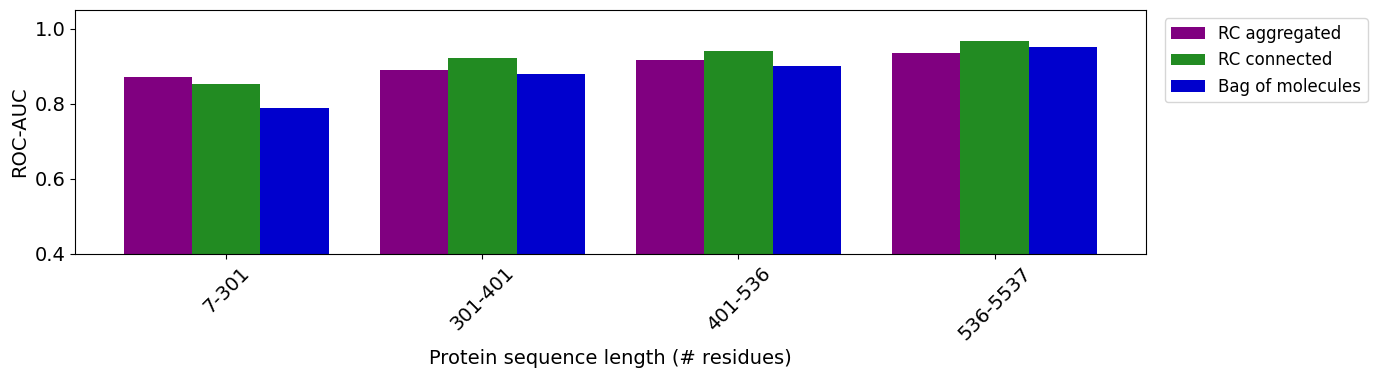

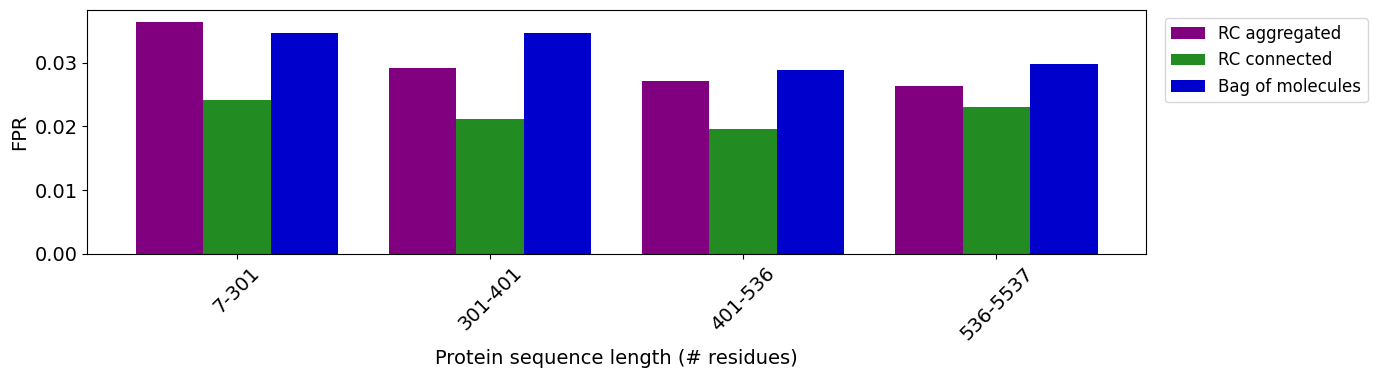

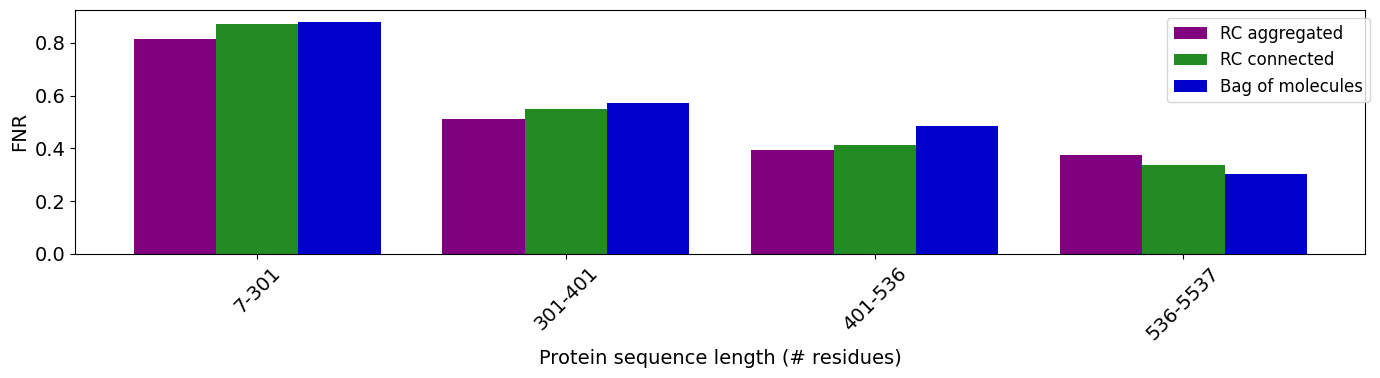

In [13]:
if task == 'rcmcs':
    clustered_bar_plot('ec1', 'roc_auc')
    clustered_bar_plot('ec1', 'fpr')
    clustered_bar_plot('ec1', 'fnr')
    clustered_bar_plot('ec2', 'roc_auc')
    clustered_bar_plot('ec2', 'fpr')
    clustered_bar_plot('ec2', 'fnr')
    
clustered_bar_plot('n_rcts_pdts', 'roc_auc')
clustered_bar_plot('n_rcts_pdts', 'fpr')
clustered_bar_plot('n_rcts_pdts', 'fnr')
clustered_bar_plot('n_atoms_chunk', 'roc_auc')
clustered_bar_plot('n_atoms_chunk', 'fpr')
clustered_bar_plot('n_atoms_chunk', 'fnr')
clustered_bar_plot('protein_seq_len_chunk', 'roc_auc')
clustered_bar_plot('protein_seq_len_chunk', 'fpr')
clustered_bar_plot('protein_seq_len_chunk', 'fnr')

In [14]:
S_rcmcs = np.load(Path(fps.results) / 'similarity_matrices' / 'sprhea_v3_folded_pt_ns_rcmcs.npy')

- get false pos errors
- get true reactoin pairs of protein
- calc rcmcs of query reaction to each of these
- get max over this

In [15]:
preds['bom'].filter((pl.col("y") == 0) & (pl.col("y_pred") == 1)).shape

(778, 15)

In [16]:
np.argmin(np.array([1, 1, 0, 1]))

np.int64(2)

In [17]:
def _get_ec_match_level(ec1: tuple[str], ec2:tuple[str]) -> int:
    '''
    Returns the highest EC level (1-4) at which two EC numbers match.
    If no match at level 1, returns 0.
    '''
    for level in range(4):
        if ec1[level] != ec2[level]:
            return level
    return 4

def get_ec_match_level(ecs1: set[tuple[str]], ecs2: set[tuple[str]]) -> int:
    '''
    Given two sets of EC numbers (as tuples), returns the highest EC level (1-4)
    at which any pair of EC numbers from the two sets match.
    If no match at level 1, returns 0.
    '''
    max_level = 0
    for ec1 in ecs1:
        for ec2 in ecs2:
            level = _get_ec_match_level(ec1, ec2)
            if level > max_level:
                max_level = level
    return max_level

In [18]:
rxn_idx2ec[678]

{('2', '3', '1', '-'),
 ('2', '3', '1', '23'),
 ('2', '3', '1', 'n6'),
 ('2', '3', '1', 'n7')}

In [60]:
cdf_whitelist = ['rc_agg', 'rc_cxn', 'bom', 'cgr', 'clipzyme', 'drfp']
if task == 'rcmcs':
    max_sim_missed = defaultdict(list)
    max_ec_match_missed = defaultdict(list)
    for k, pred in preds.items():
        if k not in cdf_whitelist:
            continue
        false_positives = pred.filter((pl.col("y") == 0) & (pl.col("y_pred") == 1))
        for row in false_positives.iter_rows(named=True):
            ridx = row['reaction_idx']
            pidx = row['protein_idx']
            i = pidx
            col_indices = adj.getrow(i).nonzero()[1]
            max_sim = S_rcmcs[ridx, col_indices].max()
            max_sim_missed[k].append(max_sim)

            ecs = rxn_idx2ec.get(ridx)
            if not ecs:
                continue

            for other_ridx in col_indices:
                other_ecs = rxn_idx2ec.get(other_ridx)
                if not other_ecs:
                    continue
                ec_match_level = get_ec_match_level(ecs, other_ecs)
                if ec_match_level == 4:
                    ec_match_level = 3
                max_ec_match_missed[k].append(ec_match_level)


In [59]:
ec_match_level

0

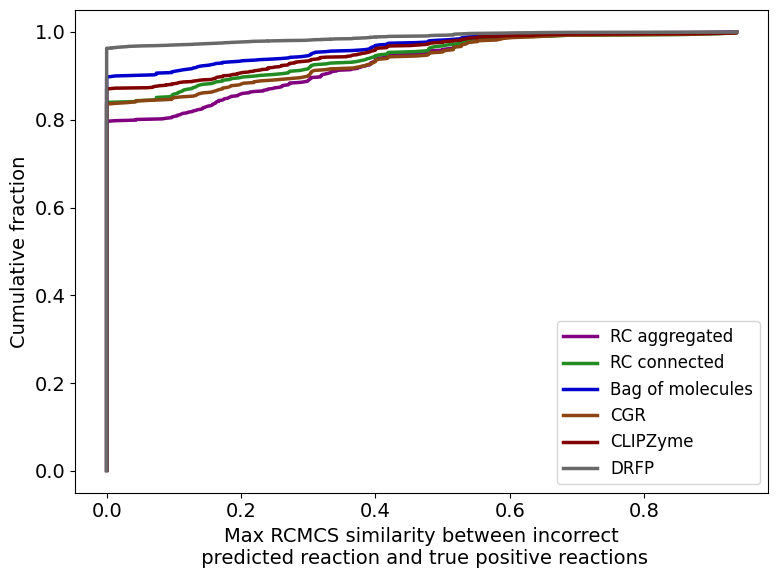

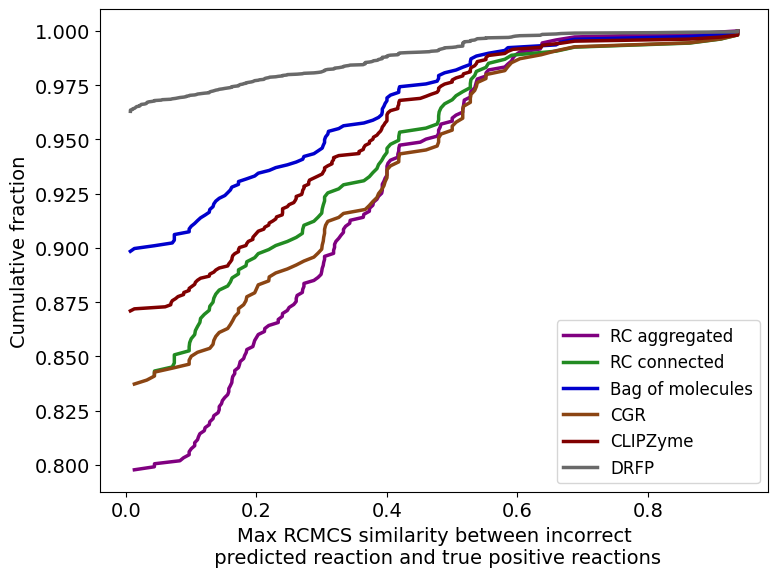

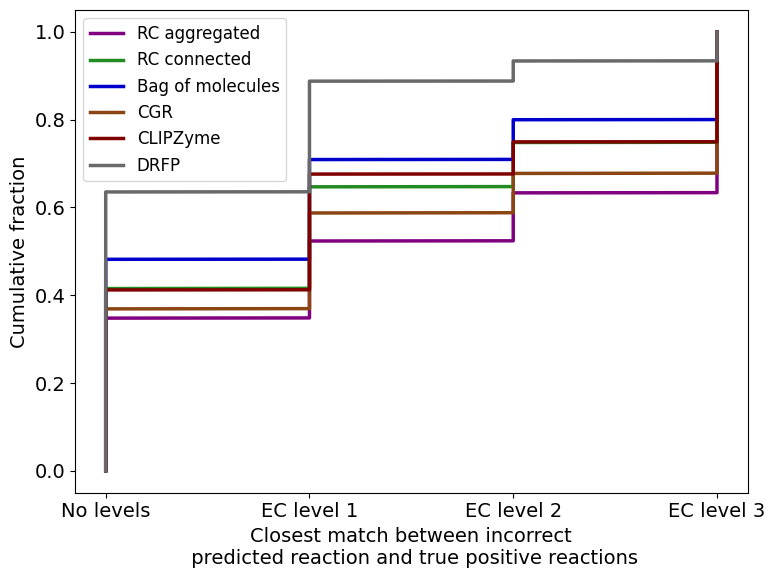

In [62]:
def max_miss_sim_cdf(max_sim_missed, colors=colors, labels=labels, x_ec=False, nz_inset=False, save_to=save_to, task=task):
    '''
    Plots CDF of maximum similarity of missed positive samples.
    '''
    fig, ax = plt.subplots(figsize=(8, 6))

    if x_ec:
        xticks = [0, 1, 2, 3]
        xtick_labels = ['No levels', 'EC level 1', 'EC level 2', 'EC level 3']
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlabel('Closest match between incorrect\n predicted reaction and true positive reactions')

    else:
        ax.set_xlabel('Max RCMCS similarity between incorrect\n predicted reaction and true positive reactions')

    for k, sims in max_sim_missed.items():
        sims_sorted = np.sort(sims)
        cdf = np.arange(1, len(sims_sorted)+1) / len(sims_sorted)

        if nz_inset:
            nz_idx = np.where(sims_sorted > 0)[0]
            sims_sorted = sims_sorted[nz_idx]
            cdf = cdf[nz_idx]
        
        ax.plot(sims_sorted, cdf, label=labels.get(k, k), color=colors.get(k), linewidth=2.5)

    
    ax.set_ylabel('Cumulative fraction')
    ax.legend()
    fig.tight_layout()

    if save_to is not None:
        save_to.mkdir(parents=True, exist_ok=True)
        suffix = "_nz_inset" if nz_inset else ""
        xpart = "_ec_match" if x_ec else ""
        fig.savefig(save_to / f"{task}_max_miss_sim_cdf{xpart}{suffix}.svg")

    return fig, ax

if task == 'rcmcs':
    max_miss_sim_cdf(max_sim_missed)
    max_miss_sim_cdf(max_sim_missed, nz_inset=True)
    max_miss_sim_cdf(max_ec_match_missed, x_ec=True)

In [21]:
ec_cdf_counts = {}
for k, v in max_ec_match_missed.items():
    ec_cdf_counts[k] = {"frac": [],}
    total = len(v)
    for level in range(5):
        count = sum(1 for elt in v if elt == level)
        cumulative_count = sum(1 for elt in v if elt > level)
        ec_cdf_counts[k]["frac"].append(count / total)

    ec_cdf_counts[k]["cumulative_frac"] = np.cumsum(ec_cdf_counts[k]["frac"][::-1])[::-1].tolist()

    print(f"MODEL: {k}")
    print("LEVEL-BASED:")
    for level in range(5):
        print(f"\tEC level {level}: {ec_cdf_counts[k]['frac'][level]:.2%}")

    print("CUMULATIVE:")

    for level in range(4):
        print(f"\tEC level >= {level}: {ec_cdf_counts[k]['cumulative_frac'][level]:.2%}")

    print('\n', '-' * 100)


MODEL: rc_agg
LEVEL-BASED:
	EC level 0: 34.79%
	EC level 1: 17.57%
	EC level 2: 10.97%
	EC level 3: 30.37%
	EC level 4: 6.29%
CUMULATIVE:
	EC level >= 0: 100.00%
	EC level >= 1: 65.21%
	EC level >= 2: 47.64%
	EC level >= 3: 36.66%

 ----------------------------------------------------------------------------------------------------
MODEL: rc_cxn
LEVEL-BASED:
	EC level 0: 41.52%
	EC level 1: 23.18%
	EC level 2: 10.10%
	EC level 3: 18.13%
	EC level 4: 7.06%
CUMULATIVE:
	EC level >= 0: 100.00%
	EC level >= 1: 58.48%
	EC level >= 2: 35.29%
	EC level >= 3: 25.19%

 ----------------------------------------------------------------------------------------------------
MODEL: bom
LEVEL-BASED:
	EC level 0: 48.19%
	EC level 1: 22.73%
	EC level 2: 9.08%
	EC level 3: 15.46%
	EC level 4: 4.54%
CUMULATIVE:
	EC level >= 0: 100.00%
	EC level >= 1: 51.81%
	EC level >= 2: 29.08%
	EC level >= 3: 20.00%

 ----------------------------------------------------------------------------------------------------
MO

In [30]:
ec_fp_fracs = defaultdict(list)
for k, levels in ec_cdf_counts.items():
    for i in range(3):
        ec_fp_fracs[k].append(levels['frac'][i])

    ec_fp_fracs[k].append(levels['frac'][3] + levels['frac'][4])

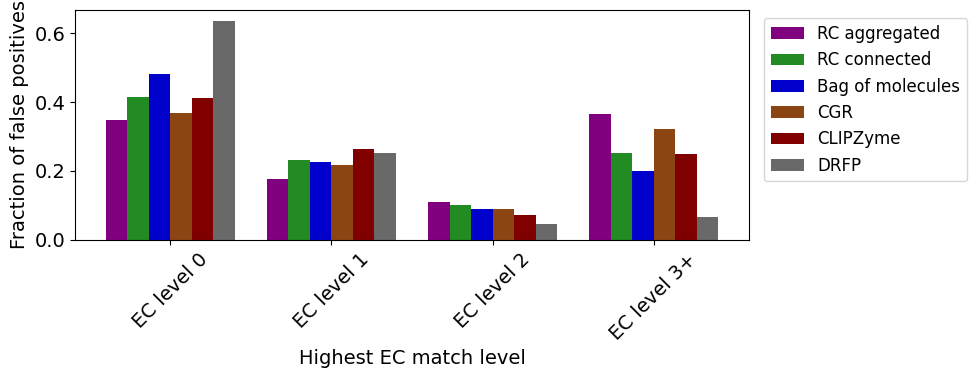

In [33]:
models = list(ec_fp_fracs.keys())
n_levels = len(next(iter(ec_fp_fracs.values())))
width = 0.8 / len(models)
level_labels = ["EC level 0", "EC level 1", "EC level 2", "EC level 3+"][:n_levels]

fig, ax = plt.subplots(figsize=(10, 4))
for j, model in enumerate(models):
    xs = [i + (j - (len(models) - 1) / 2) * width for i in range(n_levels)]
    vals = [ec_fp_fracs[model][i] for i in range(n_levels)]
    ax.bar(xs, vals, width=width, label=labels.get(model, model), color=colors.get(model))

ax.set_xticks(range(n_levels))
ax.set_xticklabels(level_labels, rotation=45)
ax.set_ylabel("Fraction of false positives")
ax.set_xlabel("Highest EC match level")
ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
fig.tight_layout()

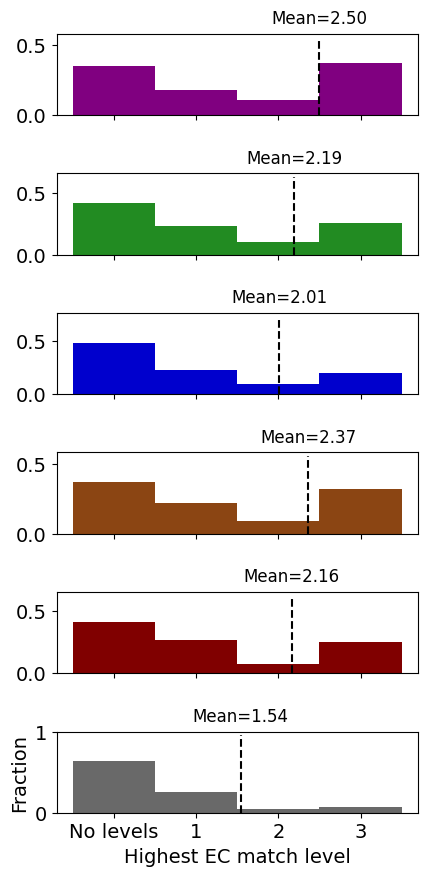

In [83]:
models = list(ec_fp_fracs.keys())
n_levels = len(next(iter(ec_fp_fracs.values())))
width = 1
level_labels = ["No levels", "1", "2", "3"][:n_levels]

fig, ax = plt.subplots(figsize=(4.5, 9), nrows=len(models), sharex=True, sharey=False)
for j, model in enumerate(models):
    weighted_average = sum(ec_fp_fracs[model][i] * (i+1) for i in range(n_levels)) / sum(ec_fp_fracs[model])
    vals = [ec_fp_fracs[model][i] for i in range(n_levels)]
    ax[j].bar(list(range(n_levels)), vals, width=width, label=labels.get(model, model), color=colors.get(model))
    ax[j].vlines(weighted_average, ymin=0, ymax=max(vals) * 1.5, colors='black', linestyles='dashed')
    ax[j].text(weighted_average, max(vals) * 1.7, f"Mean={weighted_average:.2f}", ha='center', va='bottom', fontsize=12)

ax[-1].set_xticks(range(n_levels))
ax[-1].set_xticklabels(level_labels)
ax[-1].set_ylabel("Fraction")
ax[-1].set_xlabel("Highest EC match level")
fig.tight_layout()
fig.savefig(save_to / f"{task}_max_miss_ec_stacked_hists.svg")


RXNMapper AM Experiment

In [22]:
run_ids = {
    "rc_agg": "da9ed201898a451a8a822cf1a30ec30b",
    "rc_cxn": "af29e2f62cf34bf2824dc8c72e086da5",
    "cgr": "e627a08cec3c47e18b4fd9f1ade6b9fe",
}

rm_preds = {
    k: pl.read_parquet(pred_dir / v / "rxn_mapper_am_random_target_output.parquet") for k, v in run_ids.items()
}

test_file = pl.read_parquet(
    Path(fps.scratch) / "rxn_mapper_am_v3_folded_pt_ns" / "None_random" / "Nonefold" / "test.parquet"
).select(['protein_idx', 'reaction_idx', 'rxnmapper_confidence'])

for k, pred in rm_preds.items():
    pred = pred.join(
        test_file,
        how='inner',
        on=['protein_idx', 'reaction_idx'],
    ).with_columns(
        pl.col("logits").map_elements(lambda x : x > best_thresholds[k], return_dtype=pl.Int32).alias('y_pred'),
    )
    rm_preds[k] = pred

/tmp/ipykernel_9134/223382.py:21: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("logits").map_elements(lambda x: ...)
with this one instead:
  + pl.col("logits") > k.replace_strict(best_thresholds)

  pl.col("logits").map_elements(lambda x : x > best_thresholds[k], return_dtype=pl.Int32).alias('y_pred'),
/tmp/ipykernel_9134/223382.py:21: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("logits").map_elements(lambda x: ...)
with this one instead:
  + pl.col("logits") > k.replace_strict(best_thresholds)

  pl.col("logits").map_elements(lambda x : x > best_thresholds[k], return_dtype=pl.Int32).alias('y_pred'),
/tmp/ipykernel_9134/223382.py:21: PolarsInefficientMapWarning:

In [23]:
n_chunks = 5
for k, pred in rm_preds.items():
    percentiles = np.percentile(pred['rxnmapper_confidence'].to_list(), np.linspace(0, 100, n_chunks))
    chunk_labels = [f"<{int(percentiles[0])}"] + [f"{percentiles[i]:.3f}-{percentiles[i+1]:.3f}" for i in range(len(percentiles)-1)] + [f">{percentiles[-1]:.3f}"]
    pred = pred.with_columns(
        pl.col("rxnmapper_confidence").cut(breaks=percentiles, labels=chunk_labels, left_closed=True).alias('rxnmapper_confidence_chunk')
    )
    gb = pred.group_by(f"rxnmapper_confidence_chunk").agg(
        pl.col("y").mean().alias("pos_frac"),
        pl.len().alias("n"),
    ).sort('rxnmapper_confidence_chunk')
    black_list = gb.filter(pl.col("n") < 50)['rxnmapper_confidence_chunk'].to_list()
    print(f"Excluding {black_list} for having less than 50 samples.")
    pred = pred.filter(
        ~pl.col('rxnmapper_confidence_chunk').is_in(black_list)
    )
    rm_preds[k] = pred

Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.


(<Figure size 1400x400 with 1 Axes>,
 <Axes: xlabel='RXNMapper confidence', ylabel='FNR'>)

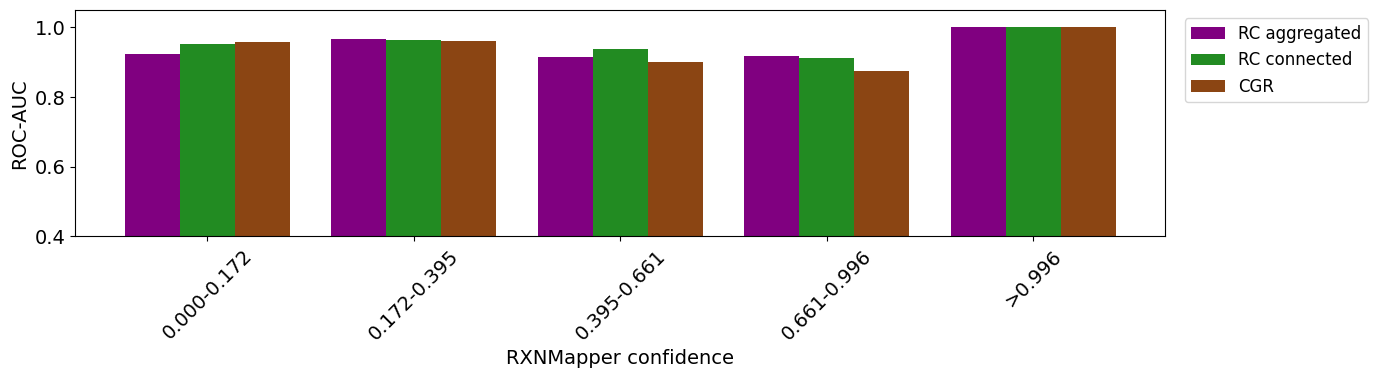

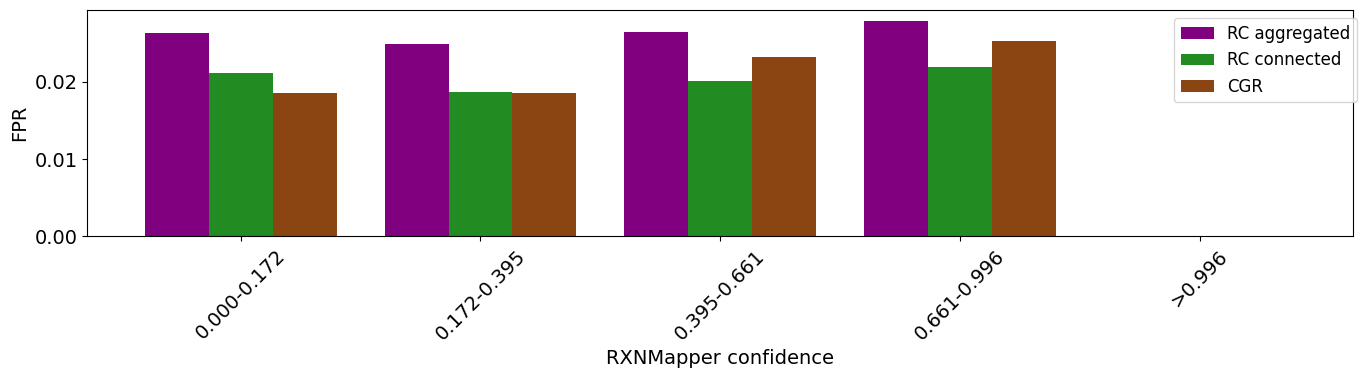

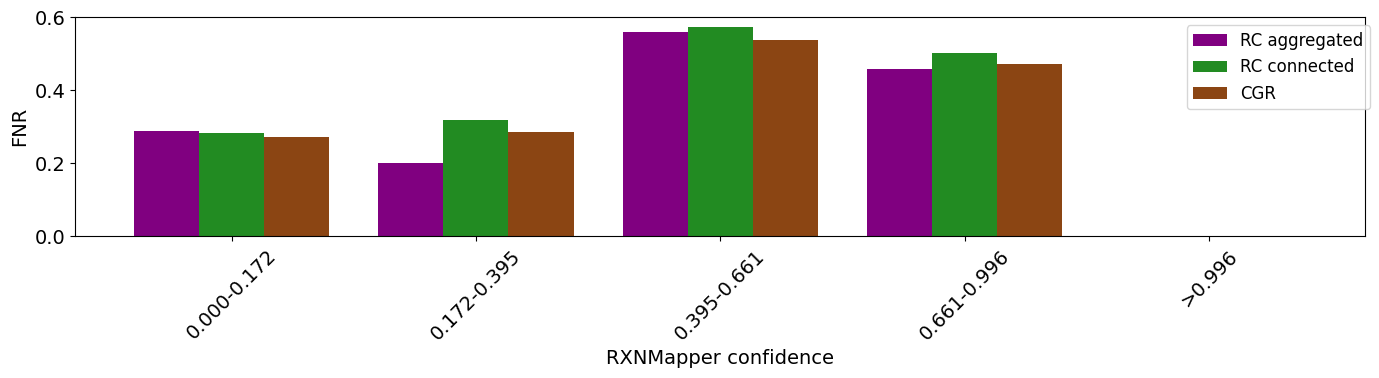

In [24]:
clustered_bar_plot('rxnmapper_confidence_chunk', 'roc_auc', preds=rm_preds)
clustered_bar_plot('rxnmapper_confidence_chunk', 'fpr', preds=rm_preds)
clustered_bar_plot('rxnmapper_confidence_chunk', 'fnr', preds=rm_preds)